<a href="https://colab.research.google.com/github/ferperezh/IIC3633_ProyectoMetricaDiversidad/blob/IKNN/pelicula/pelicula_metrica_diversidad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Métrica **Diversidad de Usuario** en la Película

## Importar los datos
Es necesario agregar el archivo "kaggle.json" disponible en el repositorio al entorno de archivos del Colab:
- https://github.com/ferperezh/IIC3633_ProyectoMetricaDiversidad/blob/main/kaggle.json

In [1]:
# Crear el directorio .kaggle en Colab
!mkdir -p ~/.kaggle

# Mover el archivo kaggle.json al directorio .kaggle
!cp kaggle.json ~/.kaggle/

# Cambiar los permisos del archivo kaggle.json para asegurar privacidad
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [2]:
!pip install kaggle
!pip install fastFM
!pip install tensorflow

In [3]:
# Descargar el dataset
!kaggle datasets download -d grouplens/movielens-20m-dataset

# Descomprimir el archivo zip descargado
import zipfile
with zipfile.ZipFile("movielens-20m-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("movielens-20m-dataset")

print("Path to dataset files: movielens-20m-dataset")

Dataset URL: https://www.kaggle.com/datasets/grouplens/movielens-20m-dataset
License(s): unknown
movielens-20m-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Path to dataset files: movielens-20m-dataset


## Procesamiento de Datasets Peliculas
Consideramos la tabla `ratings` para tener los ratings que un usuario le da a una pelicula dad. Por lo que obetenemos el promedio de rating que da cada usuario y luego consideramos solo las peliculas que estan sobre el promedio de cada usario. Esas vamos a considerar como las peliculas del usuario. Para luego hacer el join con `movie` mara obtener la metadata.

In [4]:
import pandas as pd

genome_scores = pd.read_csv('movielens-20m-dataset/genome_scores.csv')
genome_tags = pd.read_csv('movielens-20m-dataset/genome_tags.csv')
links = pd.read_csv('movielens-20m-dataset/link.csv')
movies = pd.read_csv('movielens-20m-dataset/movie.csv')
ratings = pd.read_csv('movielens-20m-dataset/rating.csv')
tags = pd.read_csv('movielens-20m-dataset/tag.csv')

Extraer muestra de ratings y movies

In [5]:
#Merge de ratings con movies
movies_data = pd.merge(ratings, movies, on='movieId', how='inner')

In [6]:
movies_data['userId'].nunique(), movies_data['movieId'].nunique()

(138493, 26744)

In [7]:
movies_data['userId'].value_counts().min()

20

In [8]:
movies_data.shape[0], movies_data.columns

(20000263,
 Index(['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres'], dtype='object'))

In [9]:
# Dividir ratings para obtener el 0.1% de los userId
from sklearn.model_selection import train_test_split

user_ids = movies_data['userId'].unique()
train_user_ids, test_user_ids = train_test_split(user_ids, test_size=0.001, random_state=42)


In [10]:
train_user_ids.shape[0], test_user_ids.shape[0]

(138354, 139)

In [11]:
movies_data_sample = movies_data[movies_data['userId'].isin(test_user_ids)]

In [12]:
movies_data_sample.shape[0], movies_data_sample['userId'].value_counts().min()

(22848, 20)

In [13]:
# Agrupar por usuario la tabla raitings para tener el rating promedio que le da a las peliculas
ratings_por_usuario = movies_data_sample.groupby('userId')['rating'].mean()
# Hacemos un round a la decima
ratings_por_usuario = ratings_por_usuario.round(1)
ratings_por_usuario

# Ahora agregamos la columna rating_mean a la tabla rating con esta informacion
movies_data_sample['rating_mean'] = movies_data_sample['userId'].map(ratings_por_usuario)

<ipython-input-13-703c3a7f694c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_data_sample['rating_mean'] = movies_data_sample['userId'].map(ratings_por_usuario)


In [14]:
# Filtramos por todos los ratings que son mayor o igual al rating_mean
movies_data_filtrados = movies_data_sample[movies_data_sample['rating'] >= movies_data_sample['rating_mean']]

In [15]:
movies_data_filtrados['userId'].value_counts().min(), movies_data_filtrados.shape[0]

(4, 12650)

In [16]:
# Filtrar por todos los userId que tengan mas de 30 movies
movies_data_filtrados = movies_data_filtrados.groupby('userId').filter(lambda x: len(x) >= 30)

In [17]:
movies_data_filtrados['userId'].value_counts().min(), movies_data_filtrados.shape[0]

(30, 11596)

Ahora las conectamos `ratings_filtrados` con la metada

In [18]:
movies_data_filtrados['userId'].value_counts().min()

30

Vemos que por pelicula tenemos varios generos separados por | . Pero consideremos todos los genermos por separados todos esos generos representan el genero de la pelicula.

Tomamos el genero relevante como el primero que parece de la lista

In [19]:
movies_data_filtrados.shape[0]

11596

In [20]:
movies_data_filtrados['relevant_genre'] = movies_data_filtrados['genres'].str.split('|').str[0]

In [21]:
movies_data_filtrados

,userId,movieId,rating,timestamp,title,genres,rating_mean,relevant_genre
487654,3288,1,4.0,2003-02-20 18:42:56,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.5,Adventure
487655,3288,10,4.0,2003-02-21 04:43:37,GoldenEye (1995),Action|Adventure|Thriller,3.5,Action
487657,3288,50,5.0,2003-02-09 22:56:16,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,3.5,Crime
487658,3288,62,4.5,2004-01-03 19:07:57,Mr. Holland's Opus (1995),Drama,3.5,Drama
487659,3288,110,3.5,2004-01-03 19:08:24,Braveheart (1995),Action|Drama|War,3.5,Action
...,...,...,...,...,...,...,...,...
19973026,138289,45722,5.0,2007-03-12 22:12:22,Pirates of the Caribbean: Dead Man's Chest (2006),Action|Adventure|Fantasy,4.1,Action
19973029,138289,47610,5.0,2007-03-13 02:39:50,"Illusionist, The (2006)",Drama|Fantasy|Mystery|Romance,4.1,Drama
19973031,138289,48780,4.5,2007-03-13 02:36:26,"Prestige, The (2006)",Drama|Mystery|Sci-Fi|Thriller,4.1,Drama
19973032,138289,49272,5.0,2007-03-12 21:59:55,Casino Royale (2006),Action|Adventure|Thriller,4.1,Action


Luego generemos un dicionario para contar con la lista de generos por pelicula. Donde contamos por usario que categorias son y cuantas. Pero el código demora mucha en correr por lo que se cuardar en el colab.  

Debes hacer una conexion con tu colab

## Categorización de cada usuario
Obtenemos el top k=5 de categorias de cada usuario

In [22]:
''' # Calcular las k categorías más vistas por cada usuario
k = 5
top_k_genres_data = []

# Itera sobre cada usuario en user
for user_id, genres in user_genre_counts.items():
  # Ordenar los los géneros por el conteo en orden descendente y tomar los k más altos
   sorted_genres = sorted(genres.items(), key=lambda x: x[1], reverse=True)[:k]
   for genre, _ in sorted_genres:
    top_k_genres_data.append({
        'userId': user_id,
        'genre_principal': genre,
        'count': genres[genre]
    })


top_k_5_categories_total = pd.DataFrame(top_k_genres_data)

# Mostrar los resultados
print("Top k = 5 géneros más vistos por usuario:")
top_k_5_categories_total '''

' # Calcular las k categorías más vistas por cada usuario\nk = 5\ntop_k_genres_data = []\n\n# Itera sobre cada usuario en user\nfor user_id, genres in user_genre_counts.items():\n  # Ordenar los los géneros por el conteo en orden descendente y tomar los k más altos\n   sorted_genres = sorted(genres.items(), key=lambda x: x[1], reverse=True)[:k]\n   for genre, _ in sorted_genres:\n    top_k_genres_data.append({\n        \'userId\': user_id,\n        \'genre_principal\': genre,\n        \'count\': genres[genre]\n    })\n\n\ntop_k_5_categories_total = pd.DataFrame(top_k_genres_data)\n\n# Mostrar los resultados\nprint("Top k = 5 géneros más vistos por usuario:")\ntop_k_5_categories_total '

# Generar Recomendaciones

Se probará con diferentes métodos de recomendación para evaluar los resultados del modelo:


## Método Most Popular:
Recomienda las peliculas más vistas o mejor rankeadas en el conjunto global de datos de entrenamiento.
- Cuenta y ordena las peliculas según número de reproducciones
- Selecciona las `k peliculas` más populares
- Alta probabilidad de recomendar contenido con hartas visualizaciones
- Mismo resultado para todos los usuarios
- Baja diversidad de recomendaciones

In [23]:
movies_data_filtrados.columns

Index(['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres',
       'rating_mean', 'relevant_genre'],
      dtype='object')

In [24]:
data_movie = movies_data_filtrados[['userId', 'movieId', 'title', 'relevant_genre']]

In [25]:
data_movie['userId'].nunique()

83

In [26]:
data_movie['userId'].value_counts().min()

30

In [27]:
# Obtener de la data_movie todos los movieId, title, relevant_genre
meta_movies = data_movie[['movieId', 'title', 'relevant_genre']]

# Eliminar los movieId duplicados
meta_movies = meta_movies.drop_duplicates(subset='movieId')

meta_movies


,movieId,title,relevant_genre
487654,1,Toy Story (1995),Adventure
487655,10,GoldenEye (1995),Action
487657,50,"Usual Suspects, The (1995)",Crime
487658,62,Mr. Holland's Opus (1995),Drama
487659,110,Braveheart (1995),Action
...,...,...,...
19972996,26425,"In-Laws, The (1979)",Action
19972998,26488,"Star Chamber, The (1983)",Action
19973005,32596,Sahara (2005),Action
19973016,40959,"Ice Harvest, The (2005)",Action


In [28]:
from sklearn.model_selection import train_test_split

data_movie_train, data_movie_test = train_test_split(
    data_movie,
    test_size=0.2,
    stratify=data_movie['userId'],  # Stratificar por `userId`
    random_state=42
)

In [29]:
data_movie_train['userId'].nunique(), data_movie_train.shape[0]

(83, 9276)

In [30]:
data_movie_test['userId'].nunique(), data_movie_test.shape[0]

(83, 2320)

In [31]:
# Contar la cantidad de recomendaciones por userId
data_movie_train['userId'].value_counts().min(), data_movie_test['userId'].value_counts().min()

(24, 6)

### Obtención de Top K Categorías

In [32]:
def get_top_k_categories(df, k):
  user_genre_df = df[['userId', 'relevant_genre']]

  # Calcular las k categorías más escuchadas por cada usuario
  top_k_categories = (
      user_genre_df.groupby(['userId', 'relevant_genre'])
      .size()  # Contar ocurrencias de cada género por usuario
      .reset_index(name='count')  # Resetear índice y nombrar la columna de conteo
      .sort_values(['userId', 'count'], ascending=[True, False])  # Ordenar por usuario y luego por conteo descendente
      .groupby('userId')  # Agrupar por usuario para obtener los top-k
      .head(k)  # Tomar los K géneros más escuchados por usuario
  )

  return top_k_categories

In [33]:
top_k_5_categories_total = get_top_k_categories(data_movie_test, 5)
top_k_5_categories_total

,userId,relevant_genre,count
0,3288,Action,13
1,3288,Adventure,5
4,3288,Drama,5
3,3288,Crime,3
2,3288,Children,1
...,...,...,...
490,138289,Action,25
491,138289,Adventure,2
492,138289,Crime,1
493,138289,Horror,1


In [34]:
# Revisar que top_k_5_categories_total todos los usuarios tiene 5 relevant_genre
top_k_5_categories_total['userId'].value_counts().min()


1

### Recomendación de Most Popular

In [35]:
list_recomendation = None

def recommend_most_popular(user, data_train, k=10):
  global list_recomendation
  if list_recomendation is not None:
    return list_recomendation
  # Agrugar por pelicula contando la cantidad de apariciones
  data_movie_count = data_train.groupby('movieId')['movieId'].count().reset_index(name='popularity')

  # Ordenar por popularity
  data_movie_count = data_movie_count.sort_values('popularity', ascending=False)
  top_k_popular_movie = data_movie_count.head(k)

  top_k_popular_movie = top_k_popular_movie['movieId'].tolist()

  list_recomendation = top_k_popular_movie

  return top_k_popular_movie



## Método Random
Recomienda peliculas de manera aleatoria del conjunto de entrenamiento.
- Selecciona `k` peliculas aleatorias
- Usado como baseline para comparaciones
- Debiese mostrar un aumento en la diversidad de las recomendaciones

In [36]:
import random

def recommend_random(user, data_train, k=10):
  # Obtener todas las peliculas unicas
  unique_movies = data_train['movieId'].unique()

  # Seleccionar k peliculas aleatorias
  random_movies = random.sample(list(unique_movies), min(k, len(unique_movies)))

  return random_movies



## Método FastFM
FastFM es un modelo basado en Factorization Machines, utilizado para generar recomendaciones. Este enfoque:

- Aprende interacciones latentes entre usuarios y canciones a partir de datos dispersos.
- Es especialmente eficaz para integrar tanto características del usuario como del contenido, además de las interacciones implícitas.
- Emplea técnicas de factorización matricial y optimización eficiente para manejar grandes conjuntos de datos.

In [37]:
from fastFM import sgd
from scipy import sparse


def recommend_fastfm(user, data_train, k=10):
# COLUMNAS: userId, movieId, title, relevant_genre
  # Creamos matriz de interacción
  us_matrix = pd.pivot_table(
    data_train,
    index='userId',
    columns='title',
    values='movieId',
    aggfunc='count',
    fill_value=0
  )
  # Expandir matriz en formato largo
  interaction_data = us_matrix.stack().reset_index()
  interaction_data.columns = ['userId', 'title', 'interaction']
  interaction_data['interaction'] = (interaction_data['interaction'] > 0).astype(int)  # Binarización

  # Crear matriz dispersa para características
  X = sparse.csc_matrix(pd.get_dummies(interaction_data[['userId', 'title']], sparse=True).values)

  # Etiquetas (1 si hubo interacción, 0 si no)
  y = interaction_data['interaction'].values

  # Creamos el modelo de FastFM fit con primera columna de objetivo.
  ffm = sgd.FMRegression(n_iter=100, rank=2)
  ffm.fit(X, y)

  # Obtener vector del usuario para predicciones
  user_movie = us_matrix.loc[user]
  unseen_movie = user_movie[user_movie == 0].index  # Canciones no escuchadas
  user_data = pd.DataFrame({'userId': [user] * len(unseen_movie), 'title': unseen_movie})

  # Matriz dispersa para predicciones
  feature_columns = pd.get_dummies(interaction_data[['userId', 'title']], sparse=True).columns
  X_user = sparse.csc_matrix(pd.get_dummies(user_data, sparse=True).reindex(columns=feature_columns).fillna(0).values)
  predicted_ratings = ffm.predict(X_user)

  # Ordenar y seleccionar las mejores recomendaciones
  user_data['predicted_rating'] = predicted_ratings
  top_recommendations = user_data.sort_values('predicted_rating', ascending=False).head(k)['title'].tolist()

  return top_recommendations


## Método DeepFM
DeepFM es un modelo avanzado para sistemas de recomendación que combina lo mejor de las Factorization Machines (FMs) y las redes neuronales profundas (Deep Learning) para capturar interacciones complejas entre características. Este enfoque:

- Factorization Machines (FMs): Capturan de manera eficiente las interacciones de segundo orden entre características, como usuario y canción, especialmente en datos dispersos.
- Redes neuronales profundas: Aprenden interacciones de mayor nivel (no lineales) entre características, mejorando la capacidad del modelo para capturar patrones complejos.
- Integra ambos componentes en un solo modelo, compartiendo los mismos embeddings para reducir la redundancia y optimizar el aprendizaje.

In [38]:
from tensorflow import keras
import tensorflow as tf
import random

# Creamos el modelo de DeepFM
def build_deepfm(input_dim):
    # Componente FM
    input_movie = keras.layers.Input(shape=(input_dim,))
    fm_linear = keras.layers.Dense(1)(input_movie)

    # Componente Deep
    deep = keras.layers.Dense(256, activation='relu')(input_movie)
    deep = keras.layers.Dropout(0.2)(deep)
    deep = keras.layers.Dense(128, activation='relu')(deep)
    deep = keras.layers.Dense(64, activation='relu')(deep)
    deep = keras.layers.Dense(1)(deep)

    # Combinar Componentes
    fm_deep = keras.layers.Concatenate()([fm_linear, deep])

    # Combinar Componentes
    output = keras.layers.Add()([fm_linear, deep])

    # Modelo
    model = keras.Model(inputs=input_movie, outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

def recommend_deepfm(user, data_train, k=10):
  # Generamos subset de datos para evaluar interacción usuario-canción
  # COLUMNAS: userId, movieId, title, relevant_relevant_genre
  user_movie = data_train[['userId', 'title', 'relevant_genre']]

  # Creamos matriz de interacción
  us_matrix = pd.pivot_table(
    user_movie,
    values='relevant_genre',           # Género es el valor de interacción
    index='userId',
    columns='title',
    aggfunc='count',
    fill_value=0
  )

  # Preparar datos para DeepFM
  X = us_matrix.values
  input_dim = X.shape[1]
  y = us_matrix.iloc[:,0].values

  # Entrenamos el modelo
  model = build_deepfm(input_dim)
  model.fit(X, y, epochs=5, batch_size=32, verbose=0)

  # Calcular las recomendaciones para el usuario
  user_vector = us_matrix.loc[user].values.reshape(1, -1)
  predictions = model.predict(user_vector).flatten()

  # Seleccionar las Top-K canciones
  movie_ids = us_matrix.columns
  already_heard = set(user_movie[user_movie['userId'] == user]['title'])

  # Filtrar y ordenar las recomendaciones
  candidate_movie = [(movie, score) for movie, score in zip(movie_ids, predictions)
                    if movie not in already_heard]
  # Si no encuentra candidatos, entones se usan las recomendaciones originales
  if not candidate_movie:
      candidate_movie = [(movie, score) for movie, score in zip(movie_ids, predictions)]

  candidate_movie.sort(key=lambda x: x[1], reverse=True)

  # Asegurarse de que hayan k recomendaciones
  if len(candidate_movie) < k:
      # Rellenar con canciones aleatorias si es necesario
      available_movie = list(set(movie_ids) - set(movie for movie, _ in candidate_movie))
      if available_movie:
        padding = random.sample(available_movie, min(k - len(candidate_movie), len(available_movie)))
        candidate_movie.extend([(movie, 0.0) for movie in padding])

  # Retornar las k recomendaciones
  recommendations = [movie for movie, _ in candidate_movie[:k]]

  return recommendations


## Método IKNN
 Recomienda películas usando filtrado colaborativo basado en usuarios (IKNN - Item K-Nearest Neighbors).

 - Calcula la similitud entre usuarios basada en las películas que han visto
 - Usa `similitud coseno` para encontrar los k usuarios más similares
 - Recomienda películas que los usuarios similares han visto pero el usuario actual no

In [39]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

class MovieIKNN:
    def __init__(self, k=20):
        self.k = k
        self.item_similarity = None
        self.item_ids = None
        self.user_ids = None

    def _create_user_item_matrix(self, df):
        """
        Crea matriz usuario-item a partir del dataframe
        """
        # Crear mapeos de IDs únicos
        unique_users = df['userId'].unique()
        unique_items = df['movieId'].unique()
        self.user_ids = {user: idx for idx, user in enumerate(unique_users)}
        self.item_ids = {item: idx for idx, item in enumerate(unique_items)}

        # Crear matriz de interacciones
        rows = []
        cols = []
        data = []

        for _, row in df.iterrows():
            user_idx = self.user_ids[row['userId']]
            item_idx = self.item_ids[row['movieId']]
            rows.append(user_idx)
            cols.append(item_idx)
            data.append(1)  # 1 para indicar interacción

        return csr_matrix((data, (rows, cols)),
                         shape=(len(unique_users), len(unique_items)))

    def fit(self, df):
        """
        Entrena el modelo con el dataframe de interacciones
        """
        # Crear matriz usuario-item
        self.user_item_matrix = self._create_user_item_matrix(df)

        # Calcular similitud entre items
        self.item_similarity = cosine_similarity(self.user_item_matrix.T)
        # Evitar que la similitud consigo mismo sea 1
        np.fill_diagonal(self.item_similarity, 0)

        return self

    def recommend(self, username, df, n_recommendations=10):
        """
        Genera recomendaciones para un usuario
        """
        if username not in self.user_ids:
            print(f"Usuario {username} no encontrado en el dataset")
            return []

        # Obtener índice del usuario
        user_idx = self.user_ids[username]

        # Obtener vector de interacciones del usuario
        user_vector = self.user_item_matrix[user_idx].toarray().flatten()

        # Calcular predicciones
        predictions = self._predict(user_vector)

        # Poner -inf en items ya escuchados
        predictions[user_vector > 0] = float('-inf')

        # Obtener top N recomendaciones
        top_idx = np.argsort(predictions)[::-1][:n_recommendations]

        # Convertir índices a nombres de canciones
        reverse_item_ids = {v: k for k, v in self.item_ids.items()}
        recommendations = [reverse_item_ids[idx] for idx in top_idx]

        return recommendations

    def _predict(self, user_vector):
        """
        Genera predicciones para un vector de usuario
        """
        # Calcular predicciones usando similitud de items
        predictions = np.dot(self.item_similarity, user_vector)

        # Normalizar predicciones
        sim_sums = np.sum(np.abs(self.item_similarity), axis=0)
        sim_sums[sim_sums == 0] = 1  # Evitar división por cero
        predictions = predictions / sim_sums

        return predictions

## Método Híbrido
Método híbrido que combina popularidad con similtud de géneros según parámetro `alpha`.

Basado parcialmente en el [Siguiente Articulo](https://marketsy.ai/blog/hybrid-recommender-systems-beginners-guide).

- `alpha`: Parámetro para balancear entre popularidad global (`1-alpha`) y preferencias de género del usuario (`alpha`)
- Balance entre descubrimiento y relevancia de la recomendación



In [40]:
def recommend_hybrid(user, data_train, k=10, alpha=0.5):
    """
    Genera recomendaciones híbridas para un usuario basado en popularidad y género preferido.

    Args:
        user: ID del usuario para quien se generan las recomendaciones.
        data_train: DataFrame de entrenamiento con las columnas: userId, movieId, title, relevant_relevant_genre.
        k: Número de recomendaciones a retornar.
        alpha: Peso entre popularidad (1-alpha) y preferencia de género (alpha).

    Returns:
        Lista de títulos de películas recomendadas.
    """
    # Calcular los scores de popularidad de películas
    popularity_scores = data_train.groupby('movieId')['userId'].count().to_dict()
    max_popularity = max(popularity_scores.values())
    normalized_popularity = {movie: count / max_popularity for movie, count in popularity_scores.items()}

    # Obtener los géneros preferidos del usuario
    user_movies = data_train[data_train['userId'] == user]
    user_genres = user_movies['relevant_genre'].value_counts().to_dict()
    total_user_movies = sum(user_genres.values())
    preferred_user_genres = {genre: count / total_user_movies for genre, count in user_genres.items()}

    # Calcular el score combinado híbrido
    hybrid_scores = {}
    for movie in data_train['movieId'].unique():
        # Score de popularidad
        movie_popularity = normalized_popularity.get(movie, 0)

        # Score de género
        movie_genre = data_train[data_train['movieId'] == movie]['relevant_genre'].iloc[0]
        genre_score = preferred_user_genres.get(movie_genre, 0)

        # Combinar Scores de popularidad y género
        hybrid_scores[movie] = (1 - alpha) * movie_popularity + alpha * genre_score

    # Filtrar las películas ya vistas por el usuario
    user_watched = set(user_movies['movieId'])
    hybrid_scores = {movie: score for movie, score in hybrid_scores.items() if movie not in user_watched}

    # Retornar las top k películas recomendadas
    top_recommendations = sorted(hybrid_scores.items(), key=lambda x: x[1], reverse=True)
    recommended_movie_ids = [movie for movie, _ in top_recommendations[:k]]

    # Obtener los títulos de las películas recomendadas
    recommended_movies = data_train[data_train['movieId'].isin(recommended_movie_ids)]['title'].unique()
    return list(recommended_movies)


In [41]:
'''
def recommend_hybrid(user, data_train, k=10, alpha=0.5):
    # Calcular los scores de popularidad de películas
    popularity_scores = data_train['movieId'].value_counts().to_dict()
    max_popularity = max(popularity_scores.values())
    normalized_popularity = {movie: count / max_popularity for movie, count in popularity_scores.items()}

    # Obtener los géneros preferidos del usuario
    user_movies = data_train[data_train['userId'] == user]
    user_genres = defaultdict(int)

    for _, row in user_movies.iterrows():
        for genre in row['genre_list']:
            user_genres[genre] += 1

    # Normalizamos los géneros según las frecuencias de películas
    total_user_movies = sum(user_genres.values())
    prefered_user_genres = {genre: count / total_user_movies for genre, count in user_genres.items()}

    # Calcular el score combinado híbrido
    hybrid_scores = {}
    for _, row in data_train.iterrows():
        movie = row['movieId']
        genres = row['genre_list']

        # Score de popularidad
        movie_popularity = normalized_popularity.get(movie, 0)

        # Score de géneros
        genre_score = sum(prefered_user_genres.get(genre, 0) for genre in genres)

        # Combinar scores de popularidad y género
        hybrid_scores[movie] = (1 - alpha) * movie_popularity + alpha * genre_score

    # Filtrar las películas ya vistas por el usuario
    user_watched = set(user_movies['movieId'])
    hybrid_scores = {movie: score for movie, score in hybrid_scores.items() if movie not in user_watched}

    # Retornar las top k películas recomendadas
    top_recommendations = sorted(hybrid_scores.items(), key=lambda x: x[1], reverse=True)
    return [movie for movie, _ in top_recommendations[:k]] '''


"\ndef recommend_hybrid(user, data_train, k=10, alpha=0.5):\n    # Calcular los scores de popularidad de películas\n    popularity_scores = data_train['movieId'].value_counts().to_dict()\n    max_popularity = max(popularity_scores.values())\n    normalized_popularity = {movie: count / max_popularity for movie, count in popularity_scores.items()}\n\n    # Obtener los géneros preferidos del usuario\n    user_movies = data_train[data_train['userId'] == user]\n    user_genres = defaultdict(int)\n\n    for _, row in user_movies.iterrows():\n        for genre in row['genre_list']:\n            user_genres[genre] += 1\n\n    # Normalizamos los géneros según las frecuencias de películas\n    total_user_movies = sum(user_genres.values())\n    prefered_user_genres = {genre: count / total_user_movies for genre, count in user_genres.items()}\n\n    # Calcular el score combinado híbrido\n    hybrid_scores = {}\n    for _, row in data_train.iterrows():\n        movie = row['movieId']\n        genres

# Calculamos Métricas:


## Metricas de Precisión
- MAP
- NDCG@5
- Precision@10
- Recall@10

In [42]:
def calculate_map(test_data, user_recommendation, user):
  relevant_items = test_data[test_data['userId'] == user]['movieId'].tolist()

  # Inicializar variables
  precision_sum = 0
  relevant_count = 0

  for i, item in enumerate(user_recommendation, start=1):
    if item in relevant_items:
      relevant_count += 1
      precision_sum += relevant_count / i

  if relevant_count > 0:
    map_value = precision_sum / relevant_count
  else:
    map_value = 0

  return map_value


In [43]:
import math

def calculate_ndcg(test_data, user_recommendation, user):
  relevant_items = test_data[test_data['userId'] == user]['movieId'].tolist()

  # Calcular DCG e IDCG
  dcg = 0
  idcg = 0
  for i, item in enumerate(user_recommendation, start=1):
    if item in relevant_items:
      dcg += 1 / math.log2(i + 1)
    idcg += 1 / math.log2(i + 1)

  # Calcular NDCG
  if idcg > 0:
    ndcg_value = dcg / idcg
  else:
    ndcg_value = 0

  return ndcg_value


In [44]:
def calculate_precision_at_k(test_data, user_recommendation, user):
  relevant_items = test_data[test_data['userId'] == user]['movieId'].tolist()

  relevant_count = 0
  for item in user_recommendation:
    if item in relevant_items:
      relevant_count += 1

  precision_at_k = relevant_count / len(user_recommendation)

  return precision_at_k

In [45]:
def calculate_recall_at_k(test_data, user_recommendation, user):
  relevant_items = test_data[test_data['userId'] == user]['movieId'].tolist()

  relevant_count = 0
  for item in user_recommendation:
    if item in relevant_items:
      relevant_count += 1

  recall_at_k = relevant_count / len(relevant_items)

  return recall_at_k


## Métricas de Diversidad: ¡Enfoque del Estudio!
- **User Diversity**: Métrica propuesta por la investigación
- Long Tail
- Shannon Entropy
- Intra List Diversity
- Diversity Coverage
- Inverse Propensity Score

### Definición de **USER DIVERSITY**, la métrica de la investigación.
1. `UD = 1 - (|∑{j=1...k}[(R_j/R)*log(R_j/R)]| / log(k))`
2. `k`: número de categorías para un usuario.
3. `R`: número total de recomendaciones.
4. `(R_j/R)`: Proporción de recomendaciones del usuario que pertenecen a la categoría `j`
5. `log(...)`: para penalizar concentración excesiva en una sola categoría.
6. `/ log(k)`: normaliza el valor.
7. `1 - `: Valor resultante entre 0 y 1.
8. *Valor alto*: alta diversidad en las recomendaciones recibidas por el usuario (pertenecen a varias categorías favoritas)

In [46]:
import math

def calculate_user_diversity(user_top_categories, user_recommendation, user_id, k=5):
    # Obtener las top k categorías del usuario
    categories_user = user_top_categories[user_top_categories['userId'] == user_id]['relevant_genre'].tolist()[:k]

    # Filtrar recomendaciones para géneros relevantes
    filtered_recommendations = [
        rec for rec in user_recommendation
        if rec in data_movie[data_movie['relevant_genre'].isin(categories_user)]['movieId'].tolist()
    ]

    # Total de recomendaciones relevantes
    r = len(filtered_recommendations)
    if r == 0:
        return 0.0  # Si no hay recomendaciones relevantes, diversidad es 0.

    # Filtrar datos de movies para las peliculas recomendadas relevantes
    filtered_data = meta_movies[meta_movies['movieId'].isin(filtered_recommendations)]


    # Calcular sum_diversity
    sum_diversity = 0
    for genre in categories_user:
        recommended_movies_genre = filtered_data[filtered_data['relevant_genre'] == genre]
        r_j = len(recommended_movies_genre)


        if r_j > 0:
            proportion = r_j / r
            contribution = proportion * math.log(proportion)
            sum_diversity += contribution

    # Normalizar con log(k)
    max_diversity = math.log(k) if k > 1 else 1.0
    # Ponemos en valor absoluto sum_diversity
    sum_diversity = abs(sum_diversity)

    if max_diversity == 0:
        return 0.0  # Si k <= 1, diversidad no tiene sentido

    # Calcular diversidad final
    diversity = 1 - (sum_diversity / max_diversity)

    # Depuración adicional
    return diversity


In [47]:
''' import math

def calculate_user_diversity(user_top_categories, user_recommendation, user_id, k=5):
    # Obtener las top k categorías del usuario
    categories_user = user_top_categories[user_top_categories['userId'] == user_id]['relevant_genre'].tolist()[:k]

    # Filtrar recomendaciones para géneros relevantes
    filtered_recommendations = []
    for rec in user_recommendation:
      genre_list = movies.copy()
      genre_list = genre_list[genre_list['movieId'] == rec]
      genre_list['genres_list'] = genre_list['genres'].str.split('|')
      genre_list = genre_list['genres_list'].tolist()
      genre_list_total = []
      for genre in genre_list:
        genre_list_total.extend(genre)
      if rec in genre_list_total:
        filtered_recommendations.append(rec)


    # Total de recomendaciones relevantes
    r = len(filtered_recommendations)
    if r == 0:
        return 0.0  # Si no hay recomendaciones relevantes, diversidad es 0.

    # Filtrar datos de movie para las peliculas recomendadas relevantes
    filtered_data = data_movie[data_movie['movieId'].isin(filtered_recommendations)]

    # Calcular sum_diversity
    sum_diversity = 0
    for genre in categories_user:
        recommended_movie_genre = filtered_data[filtered_data['genre_list'].apply(lambda x: genre in x)]['movieId'].tolist()
        r_j = len(recommended_movie_genre)

        if r_j > 0:
            proportion = r_j / r
            contribution = proportion * math.log(proportion)
            sum_diversity += contribution

    # Normalizar con log(k)
    max_diversity = math.log(k) if k > 1 else 1.0
    # Ponemos en valor absoluto sum_diversity
    sum_diversity = abs(sum_diversity)

    if max_diversity == 0:
        return 0.0  # Si k <= 1, diversidad no tiene sentido

    # Calcular diversidad final
    diversity = 1 - (sum_diversity / max_diversity)

    # Depuración adicional
    return diversity
 '''

" import math\n\ndef calculate_user_diversity(user_top_categories, user_recommendation, user_id, k=5):\n    # Obtener las top k categorías del usuario\n    categories_user = user_top_categories[user_top_categories['userId'] == user_id]['relevant_genre'].tolist()[:k]\n\n    # Filtrar recomendaciones para géneros relevantes\n    filtered_recommendations = []\n    for rec in user_recommendation:\n      genre_list = movies.copy()\n      genre_list = genre_list[genre_list['movieId'] == rec]\n      genre_list['genres_list'] = genre_list['genres'].str.split('|')\n      genre_list = genre_list['genres_list'].tolist()\n      genre_list_total = []\n      for genre in genre_list:\n        genre_list_total.extend(genre)\n      if rec in genre_list_total:\n        filtered_recommendations.append(rec)\n\n\n    # Total de recomendaciones relevantes\n    r = len(filtered_recommendations)\n    if r == 0:\n        return 0.0  # Si no hay recomendaciones relevantes, diversidad es 0.\n\n    # Filtrar dato

### **Long Tail**:
Mide que tan diversas son las recomendaciones en términos de popularidad de los items.
1.  Equación: `LT = |Intersection(Rec, TailItems)| / |Rec|`
2. Parametro `beta=0.4`: define umbral para considerar item como parte de la cola larga.
3. *Valor alto*: se recomiendan más items poco populares



In [48]:
def calculate_long_tail(test_data, user_recommendation, user_id, beta_value=0.4):
    # Total de recomendaciones relevantes
    r = len(user_recommendation)
    if r == 0:
        return 0.0  # Si no hay recomendaciones relevantes, diversidad es 0.

    # Procesamos las recomendaciones para obtener la popularidad de los items:
    item_popularity = test_data['movieId'].value_counts().to_dict()

    # Ordenamos los items por popularidad
    sorted_items = sorted(item_popularity.items(), key=lambda x: x[1], reverse=True)
    n_items = len(sorted_items)
    tail_max = int(beta_value * n_items)

    # Identificamos los items en la LT
    long_tail = set(item for item, _ in sorted_items[tail_max:])

    # Calculamos la proporcion de items recomendades nen la cola larga
    longtail_recommendation = sum(1 for item in user_recommendation if item in long_tail)

    return longtail_recommendation / r


### **Entropía de Shannon**:
Mide la incertidumbre o aleatoriedad de la distribución de recomendaciones.
1. `H = -∑(pi*log2(pi)) / log2(n)`
2. `pi`: probabilidad de cada item en las recomendaciones
3. *Valor alto*: mayor aleatoriedad/diversidad en las recomendaciones.



In [49]:
def calculate_shannon_entropy(test_data, user_recommendation, user_id):
    # Total de recomendaciones relevantes
    r = len(user_recommendation)
    if r == 0:
        return 0.0  # Si no hay recomendaciones relevantes, diversidad es 0.

    # Obtener genero de las peliculas recomendadas
    rec_genres = [
        test_data[test_data['movieId'] == rec]['relevant_genre'].iloc[0]
        for rec in user_recommendation
        if len(test_data[test_data['movieId'] == rec]) > 0
    ]

    # Si no hay generos recomendados, devolver 0
    if len(rec_genres) == 0:
        return 0.0

    # Contar la frecuencia de cada genero
    genre_counts = {genre: rec_genres.count(genre) for genre in set(rec_genres)}
    frecuencies = [count/r for count in genre_counts.values()]

    # Calcular la entropia
    entropy = -sum(p * math.log(p, 2) for p in frecuencies)

    # Normalizar con log(r)
    max_entropy = math.log(r) if r > 1 else 1.0
    entropy /= max_entropy

    return entropy

In [50]:
''' import math

def calculate_shannon_entropy(test_data, user_recommendation, user_id):
    # Total de recomendaciones relevantes
    r = len(user_recommendation)
    if r == 0:
        return 0.0  # Si no hay recomendaciones, entropía es 0.

    # Obtener géneros de las películas recomendadas
    rec_genres = []
    for rec in user_recommendation:
        movie_genres = test_data[test_data['movieId'] == rec]['relevant_genre']

        if not movie_genres.empty:
            rec_genres.extend(movie_genres.iloc[0])  # Añadir los géneros de la película

    # Si no hay géneros recomendados, devolver 0
    if len(rec_genres) == 0:
        return 0.0

    # Contar la frecuencia de cada género
    genre_counts = {genre: rec_genres.count(genre) for genre in set(rec_genres)}
    frequencies = [count / r for count in genre_counts.values()]

    # Calcular la entropía
    entropy = -sum(p * math.log(p, 2) for p in frequencies if p > 0)

    # Normalizar con log(r)
    max_entropy = math.log(r, 2) if r > 1 else 1.0
    entropy /= max_entropy

    return entropy '''


" import math\n\ndef calculate_shannon_entropy(test_data, user_recommendation, user_id):\n    # Total de recomendaciones relevantes\n    r = len(user_recommendation)\n    if r == 0:\n        return 0.0  # Si no hay recomendaciones, entropía es 0.\n\n    # Obtener géneros de las películas recomendadas\n    rec_genres = []\n    for rec in user_recommendation:\n        movie_genres = test_data[test_data['movieId'] == rec]['relevant_genre']\n\n        if not movie_genres.empty:\n            rec_genres.extend(movie_genres.iloc[0])  # Añadir los géneros de la película\n\n    # Si no hay géneros recomendados, devolver 0\n    if len(rec_genres) == 0:\n        return 0.0\n\n    # Contar la frecuencia de cada género\n    genre_counts = {genre: rec_genres.count(genre) for genre in set(rec_genres)}\n    frequencies = [count / r for count in genre_counts.values()]\n\n    # Calcular la entropía\n    entropy = -sum(p * math.log(p, 2) for p in frequencies if p > 0)\n\n    # Normalizar con log(r)\n    

### **Intra List Diversity**:
Calcula diversidad basándose en la similitud entre los items.
1. `ILD = ∑∑(d(i,j)) / (n*(n-1)/2)`
2. `d(i,j)`: es la distancia entre los items `i` y `j`, usando coseno
3. *Valor alto*: mayor diversidad entre los items recomendados.



In [51]:
import numpy as np
def calculate_intra_list_diversity(test_data, user_recommendation, user_id):
    # Total de recomendaciones relevantes
    r = len(user_recommendation)
    if r < 2:
        return 0.0

    # Crear one-hot-encoding de caracteristicas basados en generos
    unique_genres = test_data['relevant_genre'].unique()
    one_genres = {genre: id_genre for id_genre, genre in enumerate(unique_genres)}

    # Creamos los vectores one_hot
    genre_vectors = []
    for movie in user_recommendation:
        movie_data = test_data[test_data['movieId'] == movie]
        if len(movie_data) > 0:
            genre = movie_data['relevant_genre'].iloc[0]
            one_hot = [1 if one_genres[genre] == i else 0 for i in range(len(unique_genres))]
            genre_vectors.append(one_hot)

    # Si no hay recomendaciones relevantes, devolver 0
    if len(genre_vectors) < 2:
        return 0.0

    # Calcular matriz de distancias usando distancia coseno
    feature_vectors = np.array(genre_vectors)
    distances = np.dot(feature_vectors, feature_vectors.T)

    # Calcular la diversidad intra-list, considerando la distancia coseno
    n = len(feature_vectors)
    comparisons = (n * (n - 1)) / 2
    intra_list_diversity = np.sum(distances) / (2 * comparisons)

    return intra_list_diversity

In [52]:
''' import numpy as np

def calculate_intra_list_diversity(test_data, user_recommendation, user_id):
    # Total de recomendaciones relevantes
    r = len(user_recommendation)
    if r < 2:
        return 0.0  # Diversidad no se puede calcular con menos de 2 recomendaciones

    # Crear one-hot encoding de características basadas en géneros
    unique_genres = set(genre for genres in test_data['relevant_genre'] for genre in genres)
    genre_to_index = {genre: idx for idx, genre in enumerate(unique_genres)}

    # Crear vectores one-hot para cada película recomendada
    genre_vectors = []
    for movie_id in user_recommendation:
        movie_data_df = test_data[test_data['movieId'] == movie_id]
        if not movie_data_df.empty:
            genres = movie_data_df.iloc[0]['relevant_genre']
            one_hot = [1 if genre_to_index[genre] in [genre_to_index[g] for g in genres] else 0
                       for genre in unique_genres]
            genre_vectors.append(one_hot)

    # Si no hay recomendaciones relevantes, devolver 0
    if len(genre_vectors) < 2:
        return 0.0

    # Convertir los vectores a una matriz
    feature_vectors = np.array(genre_vectors)

    # Calcular matriz de similitud usando producto punto
    similarity_matrix = np.dot(feature_vectors, feature_vectors.T)
    n = len(feature_vectors)

    # Calcular la diversidad intra-lista como la distancia coseno promedio
    total_similarity = np.sum(similarity_matrix) - np.sum(np.diag(similarity_matrix))
    comparisons = n * (n - 1)  # Total de pares únicos
    intra_list_diversity = 1 - (total_similarity / comparisons)

    return intra_list_diversity
 '''


" import numpy as np\n\ndef calculate_intra_list_diversity(test_data, user_recommendation, user_id):\n    # Total de recomendaciones relevantes\n    r = len(user_recommendation)\n    if r < 2:\n        return 0.0  # Diversidad no se puede calcular con menos de 2 recomendaciones\n\n    # Crear one-hot encoding de características basadas en géneros\n    unique_genres = set(genre for genres in test_data['relevant_genre'] for genre in genres)\n    genre_to_index = {genre: idx for idx, genre in enumerate(unique_genres)}\n\n    # Crear vectores one-hot para cada película recomendada\n    genre_vectors = []\n    for movie_id in user_recommendation:\n        movie_data_df = test_data[test_data['movieId'] == movie_id]\n        if not movie_data_df.empty:\n            genres = movie_data_df.iloc[0]['relevant_genre']\n            one_hot = [1 if genre_to_index[genre] in [genre_to_index[g] for g in genres] else 0\n                       for genre in unique_genres]\n            genre_vectors.append

### **Diversity Coverage**:
Mide la cobertura como la proporción de items únicos recomendados respceto al total de items posibles.
1. `DC = |Unique_Rec| / |All Items|`
2. *Valor alto*: se están recomendando items de todo el catálogo



In [53]:
def calculate_diversity_coverage(test_data, user_recommendation, user_id):
    # Total de recomendaciones relevantes
    r = len(user_recommendation)
    if r == 0:
        return 0.0  # Si no hay recomendaciones relevantes, diversidad es 0.

    # Obtener generos unicos de las peliculas recomendadas
    rec_genres = set(
        test_data[test_data['movieId'] == rec]['relevant_genre'].iloc[0]
        for rec in user_recommendation
        if len(test_data[test_data['movieId'] == rec]) > 0
    )

    # Si no hay generos recomendados, devolver 0
    if len(rec_genres) == 0:
        return 0.0

    # Obtener todos los posibles generos
    all_genres = set(test_data['relevant_genre'].unique())

    # Calcular la cobertura de la diversidad
    diversity_coverage = len(rec_genres) / len(all_genres)

    return diversity_coverage

In [54]:
''' def calculate_diversity_coverage(test_data, user_recommendation, user_id):
    # Total de recomendaciones relevantes
    r = len(user_recommendation)
    if r == 0:
        return 0.0  # Si no hay recomendaciones, cobertura es 0.

    # Obtener géneros únicos de las películas recomendadas
    rec_genres = set()
    for rec in user_recommendation:
        movie_data = test_data[test_data['movieId'] == rec]
        if not movie_data.empty:
            rec_genres.update(movie_data.iloc[0]['relevant_genre'])

    # Si no hay géneros recomendados, devolver 0
    if len(rec_genres) == 0:
        return 0.0

    # Obtener todos los posibles géneros
    all_genres = set(genre for genres in test_data['relevant_genre'] for genre in genres)

    # Calcular la cobertura de la diversidad
    diversity_coverage = len(rec_genres) / len(all_genres)

    return diversity_coverage
 '''

" def calculate_diversity_coverage(test_data, user_recommendation, user_id):\n    # Total de recomendaciones relevantes\n    r = len(user_recommendation)\n    if r == 0:\n        return 0.0  # Si no hay recomendaciones, cobertura es 0.\n\n    # Obtener géneros únicos de las películas recomendadas\n    rec_genres = set()\n    for rec in user_recommendation:\n        movie_data = test_data[test_data['movieId'] == rec]\n        if not movie_data.empty:\n            rec_genres.update(movie_data.iloc[0]['relevant_genre'])\n\n    # Si no hay géneros recomendados, devolver 0\n    if len(rec_genres) == 0:\n        return 0.0\n\n    # Obtener todos los posibles géneros\n    all_genres = set(genre for genres in test_data['relevant_genre'] for genre in genres)\n\n    # Calcular la cobertura de la diversidad\n    diversity_coverage = len(rec_genres) / len(all_genres)\n\n    return diversity_coverage\n "

### **Inverse Propensity Score** (IPS):
Penaliza la recomendación de items muy populares
1. `IPS = (1/p(i))`
2. Parametro `lambda` para suavizar la propensidad
3. `p(i)`: probabilidad que el item `i` sea seleccionado
4. *Valor alto*: se están recomendando más items poco probables.

In [55]:
def calculate_inverse_propensity_score(test_data, user_recommendation, user_id, lambda_value=0.5):
    # Total de recomendaciones relevantes
    r = len(user_recommendation)
    if r == 0:
        return 0.0  # Si no hay recomendaciones, el IPS es 0.

    # Calcular la popularidad de las películas
    movie_popularity = test_data['movieId'].value_counts().to_dict()
    interaction_count = sum(movie_popularity.values())

    # Calcular Propensity Score
    prop_score = {
        movie: ((movie_popularity.get(movie, 0) + lambda_value) / (interaction_count + lambda_value))
        for movie in test_data['movieId'].unique()
    }

    # Calcular el IPS promedio
    ips = [1 / prop_score[movie] for movie in user_recommendation if movie in prop_score]
    if len(ips) > 0:
        ips_avg = sum(ips) / len(ips)
        return ips_avg
    else:
        return 0.0


# Ejecución Método Most Popular

Creamos una función para ejecutar el modelo con parametros modificables correspondientes a:
- `test_data`: Datos para testeo del modelo
- `train_data`: Datos para entrenamiento del modelo
- `top_n`: Para recommendación *Most Popular*
- `k`: Cuantos clusters de géneros se considerarán para los usuarios
- `beta_lt`: Parametro beta de métrica *Long Tail*, define umbral para considerar un item como parte de la *Long Tail*
- `lambda_ips`: Parámetro de métrica *Inverse Propensity Score*, sirve para suavizar el resultado.


In [56]:
def most_popular_metrics(test_data, train_data, top_n, k, beta_lt=0.4, lambda_ips=0.5):
  map_sum = 0
  ndcg_sum = 0
  precision_sum = 0
  recall_sum = 0
  diversity_sum = 0
  lt_sum = 0
  entropy_sum = 0
  ild_sum = 0
  dc_sum = 0
  ips_sum = 0
  user_count = 0


  top_k_categories_data = get_top_k_categories(test_data, k)

  for userid in test_data['userId'].unique():

    recommend_list = recommend_most_popular(userid, train_data, top_n)

    #print(f"User: {userid} - Recommended: {recommend_list}")

    # Calcular Map y nDCG y User Diversity
    map_user = calculate_map(test_data, recommend_list, userid)
    ndcg_user = calculate_ndcg(test_data, recommend_list, userid)
    precision_user = calculate_precision_at_k(test_data, recommend_list, userid)
    recall_user = calculate_recall_at_k(test_data, recommend_list, userid)

    diversity_user = calculate_user_diversity(top_k_categories_data, recommend_list, userid)
    lt_user = calculate_long_tail(test_data, recommend_list, userid, beta_lt)
    entropy_user = calculate_shannon_entropy(test_data, recommend_list, userid)
    ild_user = calculate_intra_list_diversity(test_data, recommend_list, userid)
    dc_user = calculate_diversity_coverage(test_data, recommend_list, userid)
    ips_user = calculate_inverse_propensity_score(test_data, recommend_list, userid, lambda_ips)


    map_sum += map_user
    ndcg_sum += ndcg_user
    precision_sum += precision_user
    recall_sum += recall_user
    diversity_sum += diversity_user
    lt_sum += lt_user
    entropy_sum += entropy_user
    ild_sum += ild_user
    dc_sum += dc_user
    ips_sum += ips_user
    user_count += 1

  # Promedio de métricas
  map_avg = map_sum / user_count
  ndcg_avg = ndcg_sum / user_count
  precision_avg = precision_sum / user_count
  recall_avg = recall_sum / user_count
  diversity_avg = diversity_sum / user_count
  lt_avg = lt_sum / user_count
  entropy_avg = entropy_sum / user_count
  ild_avg = ild_sum / user_count
  dc_avg = dc_sum / user_count
  ips_avg = ips_sum / user_count

  return {
      "MAP": map_avg,
      "nDCG": ndcg_avg,
      "Precision": precision_avg,
      "Recall": recall_avg,
      "User_Diversity": diversity_avg,
      "Long_Tail": lt_avg,
      "Shannon_Entropy": entropy_avg,
      "Intra_List_Diversity": ild_avg,
      "Diversity_Coverage": dc_avg,
      "Inverse_Propensity_Score": ips_avg
  }


# Ejecución Método Random

In [57]:
def random_metrcis(test_data, train_data, top_n, k, beta_lt=0.4, lambda_ips=0.5):
  map_sum = 0
  ndcg_sum = 0
  precision_sum = 0
  recall_sum = 0
  diversity_sum = 0
  lt_sum = 0
  entropy_sum = 0
  ild_sum = 0
  dc_sum = 0
  ips_sum = 0
  user_count = 0


  top_k_categories_data = get_top_k_categories(test_data, k)

  for userid in test_data['userId'].unique():

    recommend_list = recommend_random(userid, train_data, top_n)

    #print(f"User: {userid} - Recommended: {recommend_list}")

    # Calcular Map y nDCG y User Diversity
    map_user = calculate_map(test_data, recommend_list, userid)
    ndcg_user = calculate_ndcg(test_data, recommend_list, userid)
    precision_user = calculate_precision_at_k(test_data, recommend_list, userid)
    recall_user = calculate_recall_at_k(test_data, recommend_list, userid)
    diversity_user = calculate_user_diversity(top_k_categories_data, recommend_list, userid)
    lt_user = calculate_long_tail(test_data, recommend_list, userid, beta_lt)
    entropy_user = calculate_shannon_entropy(test_data, recommend_list, userid)
    ild_user = calculate_intra_list_diversity(test_data, recommend_list, userid)
    dc_user = calculate_diversity_coverage(test_data, recommend_list, userid)
    ips_user = calculate_inverse_propensity_score(test_data, recommend_list, userid, lambda_ips)

    map_sum += map_user
    ndcg_sum += ndcg_user
    precision_sum += precision_user
    recall_sum += recall_user
    diversity_sum += diversity_user
    lt_sum += lt_user
    entropy_sum += entropy_user
    ild_sum += ild_user
    dc_sum += dc_user
    ips_sum += ips_user
    user_count += 1

  # Promedio de métricas
  map_avg = map_sum / user_count
  ndcg_avg = ndcg_sum / user_count
  precision_avg = precision_sum / user_count
  recall_avg = recall_sum / user_count
  diversity_avg = diversity_sum / user_count
  lt_avg = lt_sum / user_count
  entropy_avg = entropy_sum / user_count
  ild_avg = ild_sum / user_count
  dc_avg = dc_sum / user_count
  ips_avg = ips_sum / user_count

  return {
      "MAP": map_avg,
      "nDCG": ndcg_avg,
      "Precision": precision_avg,
      "Recall": recall_avg,
      "User_Diversity": diversity_avg,
      "Long_Tail": lt_avg,
      "Shannon_Entropy": entropy_avg,
      "Intra_List_Diversity": ild_avg,
      "Diversity_Coverage": dc_avg,
      "Inverse_Propensity_Score": ips_avg
  }


# Ejecución de método IKNN

In [58]:
def IKNN_metrics(test_data, train_data, top_n, k, beta_lt=0.4, lambda_ips=0.5):
  map_sum = 0
  ndcg_sum = 0
  precision_sum = 0
  recall_sum = 0
  diversity_sum = 0
  lt_sum = 0
  entropy_sum = 0
  ild_sum = 0
  dc_sum = 0
  ips_sum = 0
  user_count = 0


  top_k_categories_data = get_top_k_categories(test_data, k)

  for userid in test_data['userId'].unique():
    model = MovieIKNN(k=20)
    model.fit(train_data)

    recommend_list = model.recommend(userid, train_data, top_n)

    #print(f"User: {userid} - Recommended: {recommend_list}")

    # Calcular Map y nDCG y User Diversity
    map_user = calculate_map(test_data, recommend_list, userid)
    ndcg_user = calculate_ndcg(test_data, recommend_list, userid)
    precision_user = calculate_precision_at_k(test_data, recommend_list, userid)
    recall_user = calculate_recall_at_k(test_data, recommend_list, userid)
    diversity_user = calculate_user_diversity(top_k_categories_data, recommend_list, userid)
    lt_user = calculate_long_tail(test_data, recommend_list, userid, beta_lt)
    entropy_user = calculate_shannon_entropy(test_data, recommend_list, userid)
    ild_user = calculate_intra_list_diversity(test_data, recommend_list, userid)
    dc_user = calculate_diversity_coverage(test_data, recommend_list, userid)
    ips_user = calculate_inverse_propensity_score(test_data, recommend_list, userid, lambda_ips)

    map_sum += map_user
    ndcg_sum += ndcg_user
    precision_sum += precision_user
    recall_sum += recall_user
    diversity_sum += diversity_user
    lt_sum += lt_user
    entropy_sum += entropy_user
    ild_sum += ild_user
    dc_sum += dc_user
    ips_sum += ips_user
    user_count += 1

  # Promedio de métricas
  map_avg = map_sum / user_count
  ndcg_avg = ndcg_sum / user_count
  precision_avg = precision_sum / user_count
  recall_avg = recall_sum / user_count
  diversity_avg = diversity_sum / user_count
  lt_avg = lt_sum / user_count
  entropy_avg = entropy_sum / user_count
  ild_avg = ild_sum / user_count
  dc_avg = dc_sum / user_count
  ips_avg = ips_sum / user_count

  return {
      "MAP": map_avg,
      "nDCG": ndcg_avg,
      "Precision": precision_avg,
      "Recall": recall_avg,
      "User_Diversity": diversity_avg,
      "Long_Tail": lt_avg,
      "Shannon_Entropy": entropy_avg,
      "Intra_List_Diversity": ild_avg,
      "Diversity_Coverage": dc_avg,
      "Inverse_Propensity_Score": ips_avg
  }


## Ejecución de metodo deepFM

In [59]:
def deepfm_metrics(test_data, train_data, top_n, k, beta_lt=0.4, lambda_ips=0.5):
  map_sum = 0
  ndcg_sum = 0
  precision_sum = 0
  recall_sum = 0
  diversity_sum = 0
  lt_sum = 0
  entropy_sum = 0
  ild_sum = 0
  dc_sum = 0
  ips_sum = 0
  user_count = 0


  top_k_categories_data = get_top_k_categories(test_data, k)
  for userid in test_data['userId'].unique():
    recommend_list = recommend_deepfm(userid, train_data, top_n)

    #print(f"User: {userid} - Recommended: {recommend_list}")

    # Calcular Map y nDCG y User Diversity
    map_user = calculate_map(test_data, recommend_list, userid)
    ndcg_user = calculate_ndcg(test_data, recommend_list, userid)
    precision_user = calculate_precision_at_k(test_data, recommend_list, userid)
    recall_user = calculate_recall_at_k(test_data, recommend_list, userid)
    diversity_user = calculate_user_diversity(top_k_categories_data, recommend_list, userid)
    lt_user = calculate_long_tail(test_data, recommend_list, userid, beta_lt)
    entropy_user = calculate_shannon_entropy(test_data, recommend_list, userid)
    ild_user = calculate_intra_list_diversity(test_data, recommend_list, userid)
    dc_user = calculate_diversity_coverage(test_data, recommend_list, userid)
    ips_user = calculate_inverse_propensity_score(test_data, recommend_list, userid, lambda_ips)

    map_sum += map_user
    ndcg_sum += ndcg_user
    precision_sum += precision_user
    recall_sum += recall_user
    diversity_sum += diversity_user
    lt_sum += lt_user
    entropy_sum += entropy_user
    ild_sum += ild_user
    dc_sum += dc_user
    ips_sum += ips_user
    user_count += 1

  # Promedio de métricas
  map_avg = map_sum / user_count
  ndcg_avg = ndcg_sum / user_count
  precision_avg = precision_sum / user_count
  recall_avg = recall_sum / user_count
  diversity_avg = diversity_sum / user_count
  lt_avg = lt_sum / user_count
  entropy_avg = entropy_sum / user_count
  ild_avg = ild_sum / user_count
  dc_avg = dc_sum / user_count
  ips_avg = ips_sum / user_count

  return {
      "MAP": map_avg,
      "nDCG": ndcg_avg,
      "Precision": precision_avg,
      "Recall": recall_avg,
      "User_Diversity": diversity_avg,
      "Long_Tail": lt_avg,
      "Shannon_Entropy": entropy_avg,
      "Intra_List_Diversity": ild_avg,
      "Diversity_Coverage": dc_avg,
      "Inverse_Propensity_Score": ips_avg
  }


## Ejecución de método FastFM

In [60]:
def fastfm_metrics(test_data, train_data, top_n, k, beta_lt=0.4, lambda_ips=0.5):
  map_sum = 0
  ndcg_sum = 0
  precision_sum = 0
  recall_sum = 0
  diversity_sum = 0
  lt_sum = 0
  entropy_sum = 0
  ild_sum = 0
  dc_sum = 0
  ips_sum = 0
  user_count = 0


  top_k_categories_data = get_top_k_categories(test_data, k)
  for userid in test_data['userId'].unique():
    recommend_list = recommend_fastfm(userid, train_data, top_n)

    #print(f"User: {userid} - Recommended: {recommend_list}")

    # Calcular Map y nDCG y User Diversity
    map_user = calculate_map(test_data, recommend_list, userid)
    ndcg_user = calculate_ndcg(test_data, recommend_list, userid)
    precision_user = calculate_precision_at_k(test_data, recommend_list, userid)
    recall_user = calculate_recall_at_k(test_data, recommend_list, userid)
    diversity_user = calculate_user_diversity(top_k_categories_data, recommend_list, userid)
    lt_user = calculate_long_tail(test_data, recommend_list, userid, beta_lt)
    entropy_user = calculate_shannon_entropy(test_data, recommend_list, userid)
    ild_user = calculate_intra_list_diversity(test_data, recommend_list, userid)
    dc_user = calculate_diversity_coverage(test_data, recommend_list, userid)
    ips_user = calculate_inverse_propensity_score(test_data, recommend_list, userid, lambda_ips)

    map_sum += map_user
    ndcg_sum += ndcg_user
    precision_sum += precision_user
    recall_sum += recall_user
    diversity_sum += diversity_user
    lt_sum += lt_user
    entropy_sum += entropy_user
    ild_sum += ild_user
    dc_sum += dc_user
    ips_sum += ips_user
    user_count += 1

  # Promedio de métricas
  map_avg = map_sum / user_count
  ndcg_avg = ndcg_sum / user_count
  precision_avg = precision_sum / user_count
  recall_avg = recall_sum / user_count
  diversity_avg = diversity_sum / user_count
  lt_avg = lt_sum / user_count
  entropy_avg = entropy_sum / user_count
  ild_avg = ild_sum / user_count
  dc_avg = dc_sum / user_count
  ips_avg = ips_sum / user_count

  return {
      "MAP": map_avg,
      "nDCG": ndcg_avg,
      "Precision": precision_avg,
      "Recall": recall_avg,
      "User_Diversity": diversity_avg,
      "Long_Tail": lt_avg,
      "Shannon_Entropy": entropy_avg,
      "Intra_List_Diversity": ild_avg,
      "Diversity_Coverage": dc_avg,
      "Inverse_Propensity_Score": ips_avg
  }


# Ejecución de método hibrido

In [61]:
def hybrid_metrics(test_data, train_data, top_n, k, alpha_hybrid=0.5, beta_lt=0.4, lambda_ips=0.5):
  map_sum = 0
  ndcg_sum = 0
  precision_sum = 0
  recall_sum = 0
  diversity_sum = 0
  lt_sum = 0
  entropy_sum = 0
  ild_sum = 0
  dc_sum = 0
  ips_sum = 0
  user_count = 0

  top_k_categories_data = get_top_k_categories(test_data, k)

  for userid in test_data['userId'].unique():

    recommend_list = recommend_hybrid(userid, train_data, top_n, alpha_hybrid)

    #print(f"User: {userid} - Recommended: {recommend_list}")

    # Calcular Map y nDCG y User Diversity
    map_user = calculate_map(test_data, recommend_list, userid)
    ndcg_user = calculate_ndcg(test_data, recommend_list, userid)
    precision_user = calculate_precision_at_k(test_data, recommend_list, userid)
    recall_user = calculate_recall_at_k(test_data, recommend_list, userid)
    diversity_user = calculate_user_diversity(top_k_categories_data, recommend_list, userid)
    lt_user = calculate_long_tail(test_data, recommend_list, userid, beta_lt)
    entropy_user = calculate_shannon_entropy(test_data, recommend_list, userid)
    ild_user = calculate_intra_list_diversity(test_data, recommend_list, userid)
    dc_user = calculate_diversity_coverage(test_data, recommend_list, userid)
    ips_user = calculate_inverse_propensity_score(test_data, recommend_list, userid, lambda_ips)

    map_sum += map_user
    ndcg_sum += ndcg_user
    precision_sum += precision_user
    recall_sum += recall_user
    diversity_sum += diversity_user
    lt_sum += lt_user
    entropy_sum += entropy_user
    ild_sum += ild_user
    dc_sum += dc_user
    ips_sum += ips_user
    user_count += 1

  # Promedio de métricas
  map_avg = map_sum / user_count
  ndcg_avg = ndcg_sum / user_count
  precision_avg = precision_sum / user_count
  recall_avg = recall_sum / user_count
  diversity_avg = diversity_sum / user_count
  lt_avg = lt_sum / user_count
  entropy_avg = entropy_sum / user_count
  ild_avg = ild_sum / user_count
  dc_avg = dc_sum / user_count
  ips_avg = ips_sum / user_count

  return {
      "MAP": map_avg,
      "nDCG": ndcg_avg,
      "Precision": precision_avg,
      "Recall": recall_avg,
      "User_Diversity": diversity_avg,
      "Long_Tail": lt_avg,
      "Shannon_Entropy": entropy_avg,
      "Intra_List_Diversity": ild_avg,
      "Diversity_Coverage": dc_avg,
      "Inverse_Propensity_Score": ips_avg
  }


# Ejecución y obtención de métricas

### Metodo Most Popular

In [ ]:
metric_results = most_popular_metrics(data_movie_test, data_movie_train, 10, 5, beta_lt=0.4, lambda_ips=0.5)
print(f"MAP: {metric_results['MAP']}")
print(f"nDCG: {metric_results['nDCG']}")
print(f"Precision: {metric_results['Precision']}")
print(f"Recall: {metric_results['Recall']}")
print(f"User_Diversity: {metric_results['User_Diversity']}")
print(f"Long_Tail: {metric_results['Long_Tail']}")
print(f"Shannon_Entropy: {metric_results['Shannon_Entropy']}")
print(f"Intra_List_Diversity: {metric_results['Intra_List_Diversity']}")
print(f"Diversity_Coverage: {metric_results['Diversity_Coverage']}")
print(f"Inverse_Propensity_Score: {metric_results['Inverse_Propensity_Score']}")

MAP: 0.2122852314304756
nDCG: 0.09535267060457382
Precision: 0.09151670951156829
Recall: 0.053959773043250565
User_Diversity: 0.36030366189414115
Long_Tail: 0.0
Shannon_Entropy: 1.990941887139338
Intra_List_Diversity: -1.2888888888888912
Diversity_Coverage: 0.5
Inverse_Propensity_Score: 290.16406461639986


### Método Random

In [ ]:
metric_results_random = random_metrcis(data_movie_test, data_movie_train, 10, 5, beta_lt=0.4, lambda_ips=0.5)
print(f"MAP: {metric_results_random['MAP']}")
print(f"nDCG: {metric_results_random['nDCG']}")
print(f"Precision: {metric_results_random['Precision']}")
print(f"Recall: {metric_results_random['Recall']}")
print(f"User_Diversity: {metric_results_random['User_Diversity']}")
print(f"Long_Tail: {metric_results_random['Long_Tail']}")
print(f"Shannon_Entropy: {metric_results_random['Shannon_Entropy']}")
print(f"Intra_List_Diversity: {metric_results_random['Intra_List_Diversity']}")
print(f"Diversity_Coverage: {metric_results_random['Diversity_Coverage']}")
print(f"Inverse_Propensity_Score: {metric_results_random['Inverse_Propensity_Score']}")

MAP: 0.008577141224956132
nDCG: 0.00321584508796055
Precision: 0.00359897172236504
Recall: 0.0013138375759688828
User_Diversity: 0.38084439206842596
Long_Tail: 0.2685089974293059
Shannon_Entropy: 0.5717658154403101
Intra_List_Diversity: 0.48641357571306076
Diversity_Coverage: 0.19037417880605673
Inverse_Propensity_Score: 7946.820348929581


Método IKNN

In [62]:
metric_results_iknn = IKNN_metrics(data_movie_test, data_movie_train, 10, 5, beta_lt=0.4, lambda_ips=0.5)
print(f"MAP: {metric_results_iknn['MAP']}")
print(f"nDCG: {metric_results_iknn['nDCG']}")
print(f"Precision: {metric_results_iknn['Precision']}")
print(f"Recall: {metric_results_iknn['Recall']}")
print(f"User_Diversity: {metric_results_iknn['User_Diversity']}")
print(f"Long_Tail: {metric_results_iknn['Long_Tail']}")
print(f"Shannon_Entropy: {metric_results_iknn['Shannon_Entropy']}")
print(f"Intra_List_Diversity: {metric_results_iknn['Intra_List_Diversity']}")
print(f"Diversity_Coverage: {metric_results_iknn['Diversity_Coverage']}")
print(f"Inverse_Propensity_Score: {metric_results_iknn['Inverse_Propensity_Score']}")

MAP: 0.03659399502772997
nDCG: 0.012656820761196154
Precision: 0.012048192771084336
Recall: 0.0030503604872046375
User_Diversity: 0.38743398759707565
Long_Tail: 0.1265060240963855
Shannon_Entropy: 0.2615688024611386
Intra_List_Diversity: 0.41741250717154327
Diversity_Coverage: 0.09370816599732254
Inverse_Propensity_Score: 1205.3159954102123


Método Deep FM

In [ ]:
metric_results_deepfm = deepfm_metrics(data_movie_test, data_movie_train, 10, 5, beta_lt=0.4, lambda_ips=0.5)
print(f"MAP: {metric_results_deepfm['MAP']}")
print(f"nDCG: {metric_results_deepfm['nDCG']}")
print(f"Precision: {metric_results_deepfm['Precision']}")
print(f"Recall: {metric_results_deepfm['Recall']}")
print(f"User_Diversity: {metric_results_deepfm['User_Diversity']}")
print(f"Long_Tail: {metric_results_deepfm['Long_Tail']}")
print(f"Shannon_Entropy: {metric_results_deepfm['Shannon_Entropy']}")
print(f"Intra_List_Diversity: {metric_results_deepfm['Intra_List_Diversity']}")
print(f"Diversity_Coverage: {metric_results_deepfm['Diversity_Coverage']}")
print(f"Inverse_Propensity_Score: {metric_results_deepfm['Inverse_Propensity_Score']}")

Método Fast FM

In [ ]:
metric_results_fastfm = fastfm_metrics(data_movie_test, data_movie_train, 10, 5, beta_lt=0.4, lambda_ips=0.5)
print(f"MAP: {metric_results_fastfm['MAP']}")
print(f"nDCG: {metric_results_fastfm['nDCG']}")
print(f"Precision: {metric_results_fastfm['Precision']}")
print(f"Recall: {metric_results_fastfm['Recall']}")
print(f"User_Diversity: {metric_results_fastfm['User_Diversity']}")
print(f"Long_Tail: {metric_results_fastfm['Long_Tail']}")
print(f"Shannon_Entropy: {metric_results_fastfm['Shannon_Entropy']}")
print(f"Intra_List_Diversity: {metric_results_fastfm['Intra_List_Diversity']}")
print(f"Diversity_Coverage: {metric_results_fastfm['Diversity_Coverage']}")
print(f"Inverse_Propensity_Score: {metric_results_fastfm['Inverse_Propensity_Score']}")

<ipython-input-37-2e0f7f25dded>:22: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  X = sparse.csc_matrix(pd.get_dummies(interaction_data[['userId', 'title']], sparse=True).values)


Método Hybrid

In [ ]:
metric_results_hybrid = hybrid_metrics(data_movie_test, data_movie_train, 10, 5, alpha_hybrid=0.5, beta_lt=0.4, lambda_ips=0.5)
print(f"MAP: {metric_results_hybrid['MAP']}")
print(f"nDCG: {metric_results_hybrid['nDCG']}")
print(f"Precision: {metric_results_hybrid['Precision']}")
print(f"Recall: {metric_results_hybrid['Recall']}")
print(f"User_Diversity: {metric_results_hybrid['User_Diversity']}")
print(f"Long_Tail: {metric_results_hybrid['Long_Tail']}")
print(f"Shannon_Entropy: {metric_results_hybrid['Shannon_Entropy']}")
print(f"Intra_List_Diversity: {metric_results_hybrid['Intra_List_Diversity']}")
print(f"Diversity_Coverage: {metric_results_hybrid['Diversity_Coverage']}")
print(f"Inverse_Propensity_Score: {metric_results_hybrid['Inverse_Propensity_Score']}")

User: 88549 - Recommended: ['Lord of the Rings: The Return of the King, The (2003)', 'Star Wars: Episode VI - Return of the Jedi (1983)', 'Fight Club (1999)', 'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)', "One Flew Over the Cuckoo's Nest (1975)", 'American Beauty (1999)', 'Jurassic Park (1993)', 'Toy Story (1995)', "Schindler's List (1993)", 'Good Will Hunting (1997)']
User: 43269 - Recommended: ['Star Wars: Episode VI - Return of the Jedi (1983)', 'Fight Club (1999)', 'Star Wars: Episode V - The Empire Strikes Back (1980)', 'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)', 'Matrix, The (1999)', 'Star Wars: Episode IV - A New Hope (1977)', 'American Beauty (1999)', 'Saving Private Ryan (1998)', "Schindler's List (1993)", 'Pulp Fiction (1994)']
User: 4494 - Recommended: ['Lord of the Rings: The Return of the King, The (2003)', 'Terminator 2: Judgment Day (1991)', 'Fight Club (1999)', 'Usual Suspects, The (1995)', 'Star 

KeyboardInterrupt: 

# Ejecución Global de Métodos

In [ ]:
def global_metrics(test_data, train_data, top_n, k, alpha_hybrid=0.5, beta_lt=0.4, lambda_ips=0.5):
  model_iknn = MovieIKNN(k=20)
  model_iknn.fit(train_data)

  # Arreglo para almacenar los resultados de cada metodo
  records = []

  # Obtenemos las top k categorias
  top_k_categories_data = get_top_k_categories(test_data, k)

  for userid in test_data['user_id'].unique():
    # Genero recomendaciones para cada modelo
    recommendations = {
        'most_popular': recommend_most_popular(userid, train_data, top_n),
        'random': recommend_random(userid, train_data, top_n),
        'iknn': model_iknn.recommend(userid, train_data, top_n),
        'fastfm': recommend_fastfm(userid, train_data, top_n),
        'deepfm': recommend_deepfm(userid, train_data, top_n),
        'hybrid': recommend_hybrid(userid, train_data, top_n, alpha_hybrid)
    }

    # Calcular Metricas para cada modelo
    for model, recommend_list in recommendations.items():
      record = {
        'user_id': userid,
        'model': model,
          # Metricas de precision
        'MAP': calculate_map(test_data, recommend_list, userid),
        'nDCG': calculate_ndcg(test_data, recommend_list, userid),
        'Precision': calculate_precision_at_k(test_data, recommend_list, userid),
        'Recall': calculate_recall_at_k(test_data, recommend_list, userid),
          # Metricas de diversidad
        'User_Diversity': calculate_user_diversity(top_k_categories_data, recommend_list, userid),
        'Long_Tail': calculate_long_tail(test_data, recommend_list, userid, beta_lt),
        'Shannon_Entropy': calculate_shannon_entropy(test_data, recommend_list, userid),
        'Intra_List_Diversity': calculate_intra_list_diversity(test_data, recommend_list, userid),
        'Diversity_Coverage': calculate_diversity_coverage(test_data, recommend_list, userid),
        'Inverse_Propensity_Score': calculate_inverse_propensity_score(test_data, recommend_list, userid, lambda_ips)
      }
      records.append(record)

  # Promedio de métricas
  results_df = pd.DataFrame(records)
  #print(results_df.head())

  return results_df


In [ ]:
results_df = global_metrics(data_movie_test, data_movie_train, 10, 5, alpha_hybrid=0.5, beta_lt=0.4, lambda_ips=0.5)
results_df.head()

## Analisis Global de Metricas
Analiza y visualiza los resultados de las métricas globales usando el Dataframe

### Generar visualizaciones comparativas entre los modelos
Creamos 3 tipos de gráficos para las visualizaciones:
1. Gráfico de cajas para cada métrica mostrando su distribución.
2. Heatmap de correlaciones entre métricas.
3. Gráfico de radar para comparar modelos.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_global_metrics(results_df):
  metrics = ['MAP', 'nDCG', 'Precision', 'Recall' , 'User_Diversity', 'Long_Tail', 'Shannon_Entropy', 'Intra_List_Diversity', 'Diversity_Coverage', 'Inverse_Propensity_Score']

  # Configurar el estilo usando seaborn
  sns.set_style

  # Crear el gráfico de cajas para cada metrica
  fig, axes = plt.subplots(3, 4, figsize=(20, 10))
  fig.suptitle('Distribución de Métricas por Modelo', fontsize=16)

  for i, metric in enumerate(metrics):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    sns.boxplot(x='model', y=metric, data=results_df, ax=axes[row, col])
    axes[row, col].set_xticklabels(axes[row, col].get_xticklabels(), rotation=45)
    ax.set_title(metric)
    ax.set_xlabel('Modelo')
    ax.set_ylabel(metric)

  plt.tight_layout()
  plt.show()

  # Generar heatmap de correlaciones entre métricas
  correlation_matrix = results_df[metrics].corr()
  plt.figure(figsize=(12, 8))
  sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
  plt.title('Correlación entre Métricas')
  plt.tight_layout()
  plt.show()

  # Grafico de radar para comparar modelos
    # Calcular promedios de las metricas normalizados
  avg_metrics = results_df.groupby('model')[metrics].mean()
  normalized_metrics = (avg_metrics - avg_metrics.min()) / (avg_metrics.max() - avg_metrics.min())

    # Configuramos grafico de radar: https://plotly.com/python/radar-chart/
  fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
  angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False)
  angles = np.concatenate((angles, [angles[0]]))

    # Graficamos las metricas
  for model in normalized_metrics.index:
    values = np.concatenate((normalized_metrics.loc[model], [normalized_metrics.loc[model][0]]))
    ax.plot(angles, values, 'o-', linewidth=2, label=model)
    ax.fill(angles, values, alpha=0.25)

    # Configuramos etiquetas
  ax.set_xticks(angles[:-1], metrics)
  ax.set_ylim(0, 1)
  plt.legend(loc='best', bbox_to_anchor=(0.5, -0.05))
  plt.title('Comparación de Métodos según Métricas Normalizadas')
  # plt.tight_layout()
  plt.show()

### Generar Análisis Estadístico de Significancia
Realiza un análisis estadístico de las diferencias entre modelos, incluyendo:
1. Media y desviación estándar por modelo.
2. Test ANOVA para evaluar la significancia estadística
3. Correlaciones entre las métricas


In [ ]:
from scipy import stats

def analyze_significance(results_df):
  metrics = ['MAP', 'nDCG', 'Precision', 'Recall', 'User_Diversity', 'Long_Tail', 'Shannon_Entropy', 'Intra_List_Diversity', 'Diversity_Coverage', 'Inverse_Propensity_Score']
  # Calcular promedios de las metricas
  avg_metrics = results_df.groupby('model').mean()
  print("Promedios de Métricas por modelo:")
  print(avg_metrics.round(4))

  # Calcular desviaciones estandar
  std_metrics = results_df.groupby('model').std()
  print("Desviaciones estandar de Métricas por modelo:")
  print(std_metrics.round(4))

  # Calcular Test de ANOVA
  # Generamos grupos de comparacion segun modelos
  anova_results = {}
  for metric in metrics:
    groups = [group for _, group in results_df.groupby('model')[metric]]
    f_value, p_value = stats.f_oneway(*groups)
    anova_results[metric] = {'Estadistico-F': f_value, 'Valor-P': p_value}

  # Creo un dataframe con los resultados
  anova_df = pd.DataFrame(anova_results).T
  print("Resultados ANOVA:")
  print(anova_df.round(4))


## Generar Resultados Finales

In [ ]:
def analyze_global_metrics(results_df):
  # Preparar e imprimir las visualizaciones usando nuestra funcion
  visualize_global_metrics(results_df)

  # Analisis estadistico usando nuestra funcion
  analyze_significance(results_df)

### **FALTA POR IMPLEMENTAR**: Testeo de Parámetros para Ejecución Global
Queda ejecutado con parámetros:
- top_n = 10
- k = 5
- alpha_hybrid=0.5
- beta_lt=0.4
- lambda_ips=0.5


In [ ]:
# Obtener dataframe de resultados
results_df = global_metrics(data_movie_test, data_movie_train, 10, 5, alpha_hybrid=0.5, beta_lt=0.4, lambda_ips=0.5)

# Analisis estadistico usando nuestra funcion
analyze_global_metrics(results_df)

# Guardar dataframe de resultados
results_df.to_csv('global_metrics_results.csv', index=False)
print("DataFrame de resultados guardado en 'global_metrics_results.csv'")

Graficar ahora con distintos `top_n`para ver como se comportan las metricas de los distintos modelos.

In [ ]:
# Actualización de los modelos
models = ['most_popular', 'iknn', 'hybrid', 'random']
metrics = ['MAP', 'nDCG', 'Precision', 'Recall', 'User_Diversity', 'Long_Tail', 'Shannon_Entropy',
           'Intra_List_Diversity', 'Diversity_Coverage', 'Inverse_Propensity_Score']
top_n_list = [5, 10, 15, 20, 25]
k_category_list = [3, 5, 7]

# Crear datos simulados nuevamente para incluir los modelos actualizados
data = []
for model in models:
    for k in k_category_list:
        for top_n in top_n_list:
            values = np.random.rand(len(metrics))
            data.append([model, k, top_n] + list(values))

# Crear DataFrame actualizado
columns = ['model', 'k', 'top_n'] + metrics
df = pd.DataFrame(data, columns=columns)

# Crear figura con filas como k y columnas como métricas
fig, axes = plt.subplots(len(k_category_list), len(metrics), figsize=(40, 12), sharex=True, sharey=False)
fig.suptitle("Metrics across Top N values for different k", fontsize=16)

for i, k in enumerate(k_category_list):
    df_k = df[df['k'] == k]  # Filtrar por k

    for j, metric in enumerate(metrics):
        ax = axes[i, j]
        for model in models:
            df_model = df_k[df_k['model'] == model]
            ax.plot(df_model['top_n'], df_model[metric], label=model, marker='o')

        if i == 0:  # Títulos de las columnas (métricas)
            ax.set_title(metric)

        if j == 0:  # Etiquetas para cada fila (k)
            ax.set_ylabel(f"k={k}")

        ax.grid(True)
        if i == len(k_category_list) - 1:  # Etiqueta del eje X solo en la última fila
            ax.set_xlabel("Top N")

        if i == 0 and j == len(metrics) - 1:  # Solo una vez, agregar leyenda
            ax.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()


In [ ]:
# Cálculo de diversity_scores
diversity_scores = {}

# Lista de top_n a evaluar
top_n_list = [5, 10, 20]

# Obtener todos los modelos únicos
models = ['most_popular', 'iknn', 'deepfm', 'fastfm', 'hybrid', 'random']

for model in models:
    scores = []
    for top_n in top_n_list:
        # Recalcular resultados para este top_n específico
        results = global_metrics(data_music_test, data_music_train, top_n, k=5)
        score = results[results['model'] == model]['User_Diversity'].mean()
        scores.append(score)
    diversity_scores[model] = scores


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Configurar el tamaño de la figura
plt.figure(figsize=(15, 8))

# Definir colores para cada modelo
colors = {
    'hybrid': '#2355a2',       # Azul oscuro
    'iknn': '#4ba3c7',         # Verde azulado
    'deepfm': '#a9cce3',       # Celeste claro
    'fastfm': '#7491bd',       # Azul grisáceo
    'most_popular': '#f8b195', # Naranja pastel
    'random': '#ff9aa2'        # Coral suave
}

# Configurar las posiciones de las barras
bar_width = 0.15
r = np.arange(len(top_n_list))

# Crear barras para cada modelo
for i, model in enumerate(models):
    # Obtener los valores precalculados de diversity_scores
    scores = diversity_scores[model]

    # Posición de las barras para este modelo
    bar_positions = r + bar_width * i

    # Crear las barras
    bars = plt.bar(bar_positions, scores,
                   width=bar_width,
                   color=colors.get(model, '#CCCCCC'),
                   label=model)

    # Añadir valores sobre las barras
    for idx, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar_width/2., height + 0.01,
                 f'{height:.2f}',
                 ha='center', va='bottom',
                 rotation=90)

# Personalizar el gráfico
plt.title('Comparación de User Diversity entre Modelos para diferentes Top N en la Música', fontsize=14, pad=20)
plt.xlabel('Top N', fontsize=12)
plt.ylabel('User Diversity Score', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7, axis='y')

# Ajustar las etiquetas del eje x
plt.xticks(r + bar_width * (len(models) - 1) / 2, top_n_list)

# Añadir leyenda
plt.legend(title='Modelos', bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajustar los márgenes
plt.tight_layout()

plt.show()

In [ ]:
# Inicializar una lista para almacenar resultados de deepfm
results_deepfm = []

# Valores de N para evaluar
top_n_values = [5, 10, 15, 20, 25, 30]

# Recolectar métricas para cada valor de N
for n in top_n_values:
    metric_results_deepfm = deepfm_metrics(
        data_movie_test,
        data_movie_train,
        n, 5,
        beta_lt=0.4,
        lambda_ips=0.5
    )
    metric_results_deepfm['N'] = n  # Agregar el valor de N
    results_deepfm.append(metric_results_deepfm)

# Convertir los resultados en un DataFrame para facilitar la visualización
results_deepfm_df = pd.DataFrame(results_deepfm)

In [ ]:
# Métricas de diversidad a graficar para deepfm
metrics_to_plot = [
    "User_Diversity", "Long_Tail", "Shannon_Entropy",
    "Intra_List_Diversity", "Diversity_Coverage", "MAP",
    "nDCG", "Precision", "Recall"
]

# Configurar el gráfico
plt.figure(figsize=(10, 6))

# Graficar cada métrica
for metric in metrics_to_plot:
    plt.plot(results_deepfm_df['N'], results_deepfm_df[metric], label=metric)

# Configurar título, etiquetas y leyenda
plt.title("Métricas de Diversidad del Modelo DeepFM en la Música")
plt.xlabel("N (Top-N Recomendaciones)")
plt.ylabel("Valor de la Métrica")
plt.legend(
    loc="upper left",            # Posición base dentro del gráfico
    bbox_to_anchor=(1.05, 1),    # Ajuste para colocarla fuera, en la esquina superior derecha
    fontsize=10,                 # Tamaño de la fuente
    borderaxespad=0              # Reducir espacio entre la leyenda y el gráfico
)
plt.grid()
plt.show()

In [64]:
# Inicializar una lista para almacenar resultados de iknn
results_iknn = []

# Valores de N para evaluar
top_n_values = [5, 10, 15, 20, 25, 30]

# Recolectar métricas para cada valor de N
for n in top_n_values:
    metric_results_iknn = IKNN_metrics(
        data_movie_test,
        data_movie_train,
        n, 5,
        beta_lt=0.4,
        lambda_ips=0.5
    )
    metric_results_iknn['N'] = n  # Agregar el valor de N
    results_iknn.append(metric_results_iknn)

# Convertir los resultados en un DataFrame para facilitar la visualización
results_iknn_df = pd.DataFrame(results_iknn)

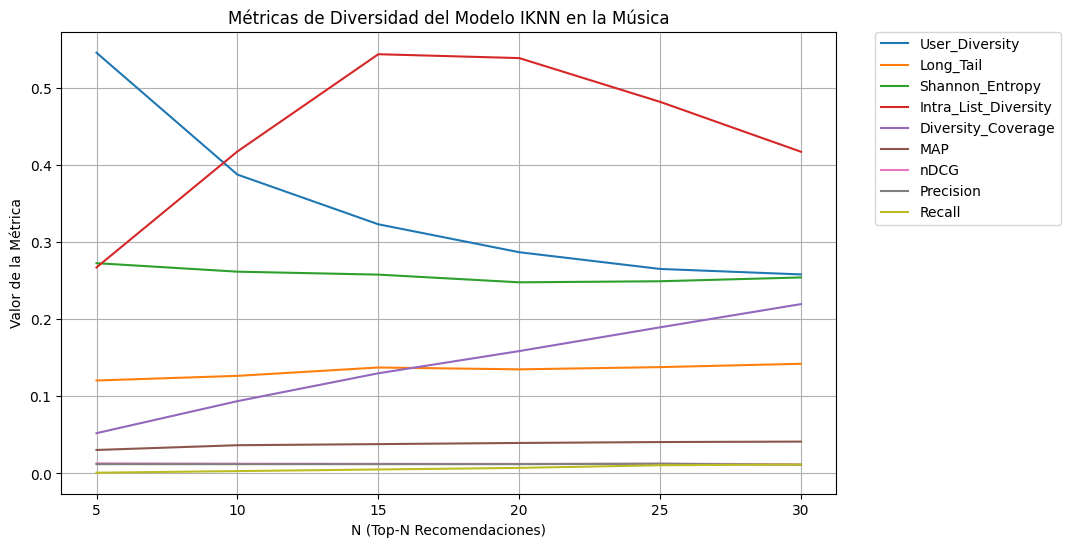

In [66]:
import matplotlib.pyplot as plt

# Métricas de diversidad a graficar para iknn
metrics_to_plot = [
    "User_Diversity", "Long_Tail", "Shannon_Entropy",
    "Intra_List_Diversity", "Diversity_Coverage", "MAP",
    "nDCG", "Precision", "Recall"
]

# Configurar el gráfico
plt.figure(figsize=(10, 6))

# Graficar cada métrica
for metric in metrics_to_plot:
    plt.plot(results_iknn_df['N'], results_iknn_df[metric], label=metric)

# Configurar título, etiquetas y leyenda
plt.title("Métricas de Diversidad del Modelo IKNN en la Música")
plt.xlabel("N (Top-N Recomendaciones)")
plt.ylabel("Valor de la Métrica")
plt.legend(
    loc="upper left",            # Posición base dentro del gráfico
    bbox_to_anchor=(1.05, 1),    # Ajuste para colocarla fuera, en la esquina superior derecha
    fontsize=10,                 # Tamaño de la fuente
    borderaxespad=0              # Reducir espacio entre la leyenda y el gráfico
)
plt.grid()
plt.show()

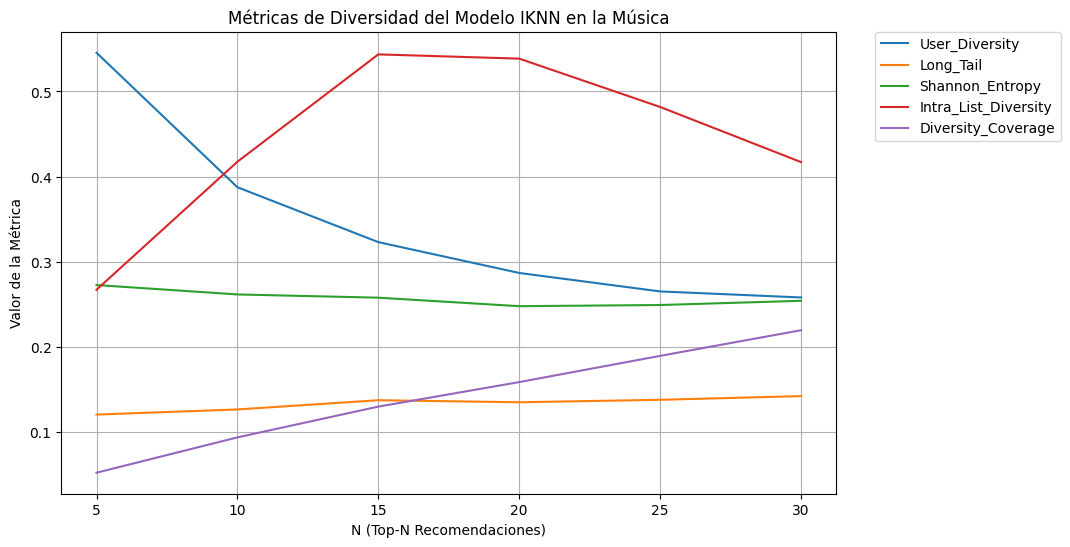

In [67]:
import matplotlib.pyplot as plt

# Métricas de diversidad a graficar para iknn
metrics_to_plot = [
    "User_Diversity", "Long_Tail", "Shannon_Entropy",
    "Intra_List_Diversity", "Diversity_Coverage"
]

# Configurar el gráfico
plt.figure(figsize=(10, 6))

# Graficar cada métrica
for metric in metrics_to_plot:
    plt.plot(results_iknn_df['N'], results_iknn_df[metric], label=metric)

# Configurar título, etiquetas y leyenda
plt.title("Métricas de Diversidad del Modelo IKNN en la Música")
plt.xlabel("N (Top-N Recomendaciones)")
plt.ylabel("Valor de la Métrica")
plt.legend(
    loc="upper left",            # Posición base dentro del gráfico
    bbox_to_anchor=(1.05, 1),    # Ajuste para colocarla fuera, en la esquina superior derecha
    fontsize=10,                 # Tamaño de la fuente
    borderaxespad=0              # Reducir espacio entre la leyenda y el gráfico
)
plt.grid()
plt.show()